<a href="https://colab.research.google.com/github/ferit-ml/lv8-leo-tumbas/blob/main/RUSU_LV8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Povratne neuronske mreže

Sekvencijalni podaci su vrsta podataka koja je organizirana u određenom slijedu (redoslijedu). To znači da redoslijed podataka ima značajnu ulogu i ne možemo ga zanemariti prilikom modeliranja. Sekvencijalni podaci često se susreću u vremenskim serijama, nizovima znakova, jezicima, ili bilo kojem drugom kontekstu gdje postoji uzastopnost elemenata.

Povratne neuronske mreže (*Recurrent Neural Networks* – RNN) su vrsta umjetnih neuronskih mreža koja je prikladna za modeliranje sekvencijalnih podataka ili podataka vremenske serije. Za razliku od tradicionalnih neuronskih mreža, RNN-ovi imaju unutarnju petlju koja omogućuje prenošenje informacija iz prethodnih koraka u trenutni korak, čime se omogućuje modeliranje temporalnih zavisnosti u podacima. Glavni problem s klasičnim RNN-ovima je problem nestajućeg (*vanishing gradient problem*) ili eksplodirajućeg gradijenta (*exploding gradient*) tijekom treniranja na dugim sekvencama podataka.

Skirveno stanje (izlaz) iz RNN-a definiran je na sljedeći način:

$$h_t = tanh(x_tW_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})$$

Gdje su:
 - $h_t$ - skriveno stanje u trenutku $t$ (*hidden state*)
 - $x_t$ - ulaz u trenutku $t$
 - $h_{t-1}$ - skriveno stanje u prethodnom koraku, odnosno inicijalno stanje u trenutku 0


 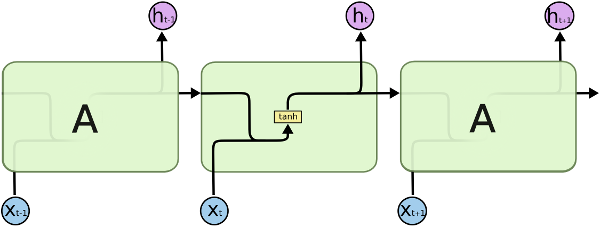


### LSTM (*Long Short-Term Memory*)

LSTM ćelija je memorijska ćelija koja zamjenjuje klasični skriveni sloj u RNN. Uvodi se vektor stanja ćelije $c$ koji samo pamti dosadašnje stanje (predstavlja „dugoročno pamćenje”). Protok informacija u ovoj memorijskoj ćeliji se kontrolira pomoću nekoliko računskih jedinica (često se nazivaju vratima).

Izlazi iz tih računskih jedinica, skriveno stanje i stanje ćelije računaju se na sljedeći način:
$$f_t = \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})$$
$$i_t = \sigma(W_{ii}x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})$$
$$g_t = tanh(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hf})$$
$$o_t = \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})$$
$$c_t = f_t \odot c_{t-1} + i_t \odot g_t$$
$$h_t = o_t \odot tanh(c_t)$$

Gdje su:
 - $f_t$ - vrata zaboravljanja (*forget gate*)
 - $i_t$ - ulazna vrata (*input gate*)
 - $g_t$ - kandidatna vrijednost (*candidate state values*)
 - $o_t$ - izlazna vrata (*output gate*)
 - $c_t$ - stanje ćelije u trenutku $t$ (*cell state*)

$\sigma$ predstavlja sigmoid aktivacijsku funkciju, a $\odot$ predstavlja množenje po elementima (*element wise multiplication*).

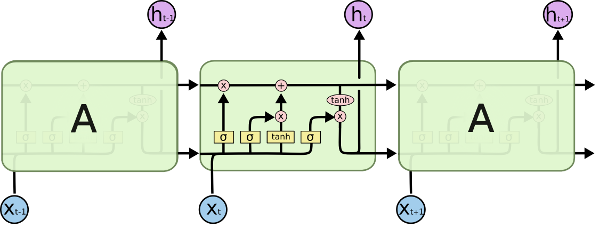

In [1]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchsummary import summary

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

Device cpu


### UDPOS podatkovni skup

[UDPOS](https://github.com/arthurdjn/udpos) podatkovni skup sastoji se od velikog broja rečenica u kojima je svaka riječ označena. Podatkovni skup dostupan je i u [PyTorchu](https://pytorch.org/text/0.13.0/datasets.html?highlight=udpos#udpos). Dostupna su dva tipa oznaka: [ud tags](https://universaldependencies.org/u/pos/) i [ptb tags](https://gucorpling.org/ptb_tags.html). U sljedećoj ćeliji prikazane su udtags oznake s pripadajućim objašnjenjima. Svakoj riječi i interpunkcijskom znaku prirdužena je po jedna oznaka.

In [2]:
tag_to_class_name = {
    'ADJ': 'adjective',
    'ADP': 'adposition',
    'ADV': 'adverb',
    'AUX': 'auxiliary',
    'CCONJ': 'coordinating conjunction',
    'DET': 'determiner',
    'INTJ': 'interjection',
    'NOUN': 'noun',
    'NUM': 'numeral',
    'PART': 'particle',
    'PRON': 'pronoun',
    'PROPN': 'proper noun',
    'PUNCT': 'punctuation',
    'SCONJ': 'subordinating conjunction',
    'SYM': 'symbol',
    'VERB': 'verb',
    'X': 'other',
    '<UNK>': 'unknown'
}

Kako bi se kreirao podatkovni skup prikladan za treniranje povratne neuronske mreže, potrebno je odraditi nekoliko stvari. Za ovu obradu podataka, u nastavku je dana klasa `TextDataset`.

Prvi korak je izdvajanje rečenica i oznaka iz podatkovnog skupa. Nakon što se izdvoje sve rečenice, potrebno je izraditi rječnik koji će sadržavati riječi iz podatkovnog skupa. Konstruktoru se predaje argument `min_occurances` koji definira koliko puta se pojedina riječ treba pojaviti u podatkovnom skupu kako bi ona bila dodana u rječnik. Rječnik je definiran na način da se svakoj riječi pridružuje različit indeks. U rječnik se prvo dodaje nova "riječ" za nepoznate riječi ili riječi koje se ne pojavljuju dovoljno, `<unk>`, kojoj je pridružen indeks 0. Nakon toga je svakoj riječi, koja se pojavljuje minimalno `min_occurances` puta, pridružen različit indeks.

U nastavku predloška je objašnjeno kako će neuronska mreža raditi s ovim rječnikom, ali je bitno da je taj rječnik konzistentan, stoga se isti rječnik treba koristiti i za trening podatke i za ostale podatke. Za zadavanje već definiranog rječnika, koristi se argument `dictionary`.

Nakon što se kreira rječnik, potrebno je svaku rečenicu pretvoriti u indeksirani oblik, odnosno u oblik gdje je svaka riječ zamijenjena pripadajućim indeksom iz rječnika. Riječima koje se ne pojavljuju u rječniku pridružen je indeks 0 kao što je ranije spomenuto.

U slučaju kreiranja podatkovnog skupa, na sličan način su obrađene i oznake riječi. Također je moguće zadati klase ako se ne radi o skupu za treniranje pomoću argumenta `classes`. Među klase je dodan i indeks -1 koji se može koristiti za označavanje riječi koje ne treba klasificirati. Funkcija gubitka će ignorirati ovu klasu. Pomoću argumenta `ignore_unknown` se definira želimo li označiti sve riječi koje nisu prisutne u rječniku oznakom -1 ili ne.

Funkcija `__getitem__` je definirana na takav način da joj se može predati jedan indeks standardno te će ona vratiti uređeni par indeksirane rečenice i indeksiranih oznaka za tu rečenicu. Također je moguće predati i par (*tuple*) ovoj funkciji kako bi se dobila uređena trojka indeksirane rečenice, originalne rečenice i indeksiranih oznaka za tu rečenicu.

In [3]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
  def __init__(self, datapipe, min_occurances = 2, dictionary=None, classes=None, ignore_unknown=False):
    self.word_sentences = []
    self.tags = []
    for sentence, udtag, _ in datapipe:
      self.word_sentences.append(self.to_lower(sentence))
      self.tags.append(udtag)
    self.word_counts = self.get_word_counts(self.word_sentences)
    if dictionary is None:
      self.dictionary = self.build_dictionary(self.word_counts, min_occurances)
    else:
      self.dictionary = dictionary

    self.indexed_sentences = []
    for sentence in self.word_sentences:
      self.indexed_sentences.append(self.words_to_indices(sentence))
    self.indexed_tags = self.tags_to_indices(self.tags, ignore_unknown, self.indexed_sentences, classes)
  def to_lower(self, sentence):
    return [word.lower() for word in sentence]
  def get_word_counts(self, sentences):
    word_counts = {}
    for sentence in sentences:
      for word in sentence:
        if word not in word_counts:
          word_counts[word] = 0
        word_counts[word] += 1
    sorted_word_counts = sorted(word_counts.items(), key=lambda x:-x[1])
    return sorted_word_counts
  def build_dictionary(self, word_counts, min_occurances = 2):
    ## padding_idx = 0
    dictionary = {'<unk>': 0}
    filtered_word_counts = dict(filter(lambda x:x[1] >= min_occurances, word_counts))
    for word in filtered_word_counts.keys():
      if word not in dictionary:
        dictionary[word] = len(dictionary)
    return dictionary
  def words_to_indices(self, sentence):
    new_sentence = []
    for word in sentence:
      if word in self.dictionary:
        new_sentence.append(self.dictionary[word])
      else:
        ## padding_idx = 0
        new_sentence.append(self.dictionary['<unk>'])
    return torch.tensor(new_sentence, dtype=torch.int64)

  def tags_to_indices(self, tags, ignore_unknown, sentences, classes):
    if classes is None:
      classes = {}
      for tag in tags:
        for t in tag:
          if t not in classes:
            classes[t] = len(classes)
      if ignore_unknown:
        ## ignore class = -1
        classes['<UNK>'] = -1
      self.classes = classes
    self.idx_to_cls = {v: k for k, v in classes.items()}
    new_tags = []
    for i, tag in enumerate(tags):
      new_tag = []
      for j, t in enumerate(tag):
        ## padding_idx = 0
        if ignore_unknown and sentences[i][j] == 0:
          new_tag.append(classes['<UNK>'])
        else:
          new_tag.append(classes[t])
      new_tags.append(torch.tensor(new_tag, dtype=torch.int64))
    return new_tags

  def __len__(self):
    return len(self.indexed_sentences)
  def __getitem__(self, idx):
    if type(idx) is tuple and idx[1] == True:
      idx = idx[0]
      return self.indexed_sentences[idx], self.word_sentences[idx], self.indexed_tags[idx]
    return self.indexed_sentences[idx], self.indexed_tags[idx]

#### `collate_fn`

`DataLoader` klasa može primati za argument funkciju za slaganje serija (*collate function*). Ova funkcija definira na koji način će se slagati serija (*batch*) podataka. Potrebna nam je posebno definirana funkcija za slaganje serija jer su podaci iz podatkovnog skupa različitih duljina, odnosno, rečenice mogu biti različitih duljina. Kako bismo mogli kreirati *batcheve* s ovakvim podacima i obrađivati ih paralelno kao do sada, potrebno je obraditi ove podatke. Ovdje se to radi na način da se odredi najdulja rečenica u *batchu* te se sve druge rečenice popune vrijednosti 0 kako bi bile jednake duljine kao najdulja rečenica. Isto se učini i s oznaka, ali se popunjavaju vrijednosti -1. Prethodno smo definirali da se koristi indeks 0 za nepoznate riječi i indeks -1 za oznake koje će funkcija gubitka ignorirati.

In [4]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  data = [item[0] for item in batch]
  target = [item[1] for item in batch]
  data = pad_sequence(data, True, 0)
  target = pad_sequence(target, True, -1)
  return (data, target)

#### Podatkovni skup

In [5]:
%%capture
!pip install portalocker>=2.0.0

In [6]:
batch_size = 32
ignore_unknown = True

In [21]:
from torchtext.datasets import UDPOS
from torch.utils.data import DataLoader

train_datapipe = UDPOS(root='./data/UDPOS', split='train')
train_dataset = TextDataset(train_datapipe, min_occurances=2, ignore_unknown=ignore_unknown)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

## TODO Define datasets and dataloader for validation and testing

val_datapipe = UDPOS(root='./data/UDPOS', split='valid')
val_dataset = TextDataset(val_datapipe, min_occurances = 2, dictionary = train_dataset.dictionary, classes = train_dataset.classes, ignore_unknown=ignore_unknown)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

test_datapipe = UDPOS(root='./data/UDPOS', split='test')
test_dataset = TextDataset(test_datapipe, min_occurances = 2, dictionary = train_dataset.dictionary, classes = train_dataset.classes, ignore_unknown=ignore_unknown)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn)

Neki korisni atributi `TextDataset` klase su:
 - `word_counts`
 - `dictionary`
 - `idx_to_class`

In [ ]:
train_dataset.word_counts[:10], dict(list(train_dataset.dictionary.items())[:10])

In [ ]:
tag_to_class_name[train_dataset.idx_to_cls[train_dataset[0][1][0].item()]]

### Embedding

Prije nego li mreža može raditi s riječima, potrebno je kodirati riječi u smislene reprezentacije. Jedan od način za ovo je pomoću tzv. *embedding* sloja. *Embedding* sloj je svojevrsna *lookup* tablica gdje je svakoj riječi iz rječnika pridružen višedimenzionalni vektor. Tijekom treniranja, cilj je naučiti smislene reprezentacije riječi. Reprezentacije riječi sličnog ili povezanog značenja bi trebale biti *blizu* u tom višedimenzionalnom prostoru, dok bi reprezentacije riječi nepovezanih značenja trebale biti udaljenije. Primjerice, riječi "pas" i "cuko" bi trebale imati slične reprezentacije, dok bi reprezentacije riječi "crvenkapica" i "računalo" trebale biti udaljene jer nemaju povezano značenje.

Embedding sloj može imati `padding_idx` koji definira indeks koji se koristi za popunjavanje. Embedding "riječi" s tim indeksom će uvijek biti ispunjen nulama i neće se trenirati. U gore definiranom podatkovnom skupu, zadano je da je taj indeks 0.

### Napomene

U nastavku slijede neke napomene koje mogu biti bitne za rješavanje ovog LV-a.

*CrossEntropyLoss* prima `ignore_index` argument koji govori funkciji gubitka da ignorira instance gdje je istinita (GT) klasa jednaka zadanom indeksu.

In [ ]:
dummy_loss_module = nn.CrossEntropyLoss(ignore_index=-1)

Navedena funckija gubitka očekuje dva ulaza, predviđene klase bez aktivacije i stvarne (GT) klase. Predviđene klase trebaju biti oblika `(batch, num_classes)`, a stvarne klase oblika `(batch)`. Ovo dosad nije bio problem pošto su nam mreže davale upravo takav izlaz, no sad će nam izlaz iz mreže biti oblika `(batch, sentence_size, num_classes)`, a oblik oznaka stvarnih klasa `(batch, sentence_size)`. Kako bismo prilagodili podatke, moguće je koristiti funkciju `view`.

Funkcija `view` se poziva na tenzoru i vraća tenzor zadanog oblika, nalik na funckiju `reshape` iz Numpy biblioteke. Ako se toj funkciji zada parametar `-1` za određenu os, veličina po toj osi će se automatski izračunati kako bi se ukupna veličina tenzora sačuvala. Primjerice, ako imamo tenzor oblika `(4, 4)` i pozovemo na njemu funkciju `view(-1, 2)`, dobit ćemo tenzor oblike `(8, 2`). Ovo nam je bitno jer nam veličina "*batcha*" neće biti konzistentna, odnosno veličina podataka koje nam neuronska mreža vraća, ovise i o veličini *batcha* (što je konzistentno) i o duljini najduže rečenice u tom *batchu* (što nije konzistentno).

In [ ]:
dummy_num_classes = 10
dummy_batch_size = 8
dummy_sentence_size = torch.randint(4, 11, (1,1)).item()

dummy_GT_label = torch.randint(0, dummy_num_classes, (dummy_batch_size, dummy_sentence_size))
dummy_predictions = torch.rand((dummy_batch_size, dummy_sentence_size, dummy_num_classes))

## incorrect loss calculaction
print('target shape:', dummy_predictions.shape, 'label shape:', dummy_GT_label.shape)
try:
  dummy_loss_module(dummy_predictions, dummy_GT_label)
except Exception as exc:
  print('Exception (wrong target shape):', exc)

## also incorrect loss calculation
print('target shape:',dummy_predictions.view(-1, dummy_num_classes).shape, 'label shape:', dummy_GT_label.shape)
try:
  dummy_loss_module(dummy_predictions.view(-1, dummy_num_classes), dummy_GT_label)
except Exception as exc:
  print('Exception (wrong label shape):', exc)

## correct loss calculation
print('target shape:',dummy_predictions.view(-1, dummy_num_classes).shape, 'label shape:', dummy_GT_label.view(-1).shape)
dummy_loss_module(dummy_predictions.view(-1, dummy_num_classes), dummy_GT_label.view(-1))

Dosad nam je ulaz u linearni sloj uvijek bio oblika `(batch_size, prev_hidden_dim)`, a izlaz `(batch_size, hidden_dim)`, gdje su `prev_hidden_dim` i `hidden_dim` veličine ulaznog i izlaznog vektora u taj linearni sloj. Linearni sloj ne mora primati ulaz tog oblika, nego prima ulaz oblika `(*, prev_hidden_dim)`, a vraća izlaz oblika `(*, hidden_dim)`, gdje `*` predstavlja proizvoljan broj dimenzija. Upravo zbog ovoga, ne moramo modificirati oblik podataka prije provlačenja kroz linearni sloj kao što je to potrebno za funkciju gubitka.

In [ ]:
dummy_hidden_dim = 100

dummy_LSTM_output = torch.rand((dummy_batch_size, dummy_sentence_size, dummy_hidden_dim))

dummy_relu_layer = nn.ReLU()
dummy_linear_layer = nn.Linear(dummy_hidden_dim, dummy_num_classes)

print('LSTM output shape:', dummy_LSTM_output.shape)

x = dummy_relu_layer(dummy_LSTM_output)
x = dummy_linear_layer(x)

print('Linear layaer output shape:', x.shape)

## Zadaci

1. Na temelju koda za kreiranje podatkovnog skupa i *dataloadera* za treniranje, kreirajte iste za validaciju i testiranje.
2. Izgradite model povratne neuronske mreže za označavanje teksta korištenjem [*Embedding*](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) i [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) slojeva. Izlaze iz LSTM-a provucite kroz *Linear* sloj kako biste dobili konačne oznake za svaku riječ ulaznih rečenica. Nakon LSTM sloja dodajte aktivacijsku funkciju, ali nemojte dodati aktivacijsku funkciju nakon posljednjeg linearnog sloja.
3. Nadopunite funkcije za evaluaciju i treniranje modela te istrenirajte i evaluirajte model. Za funkciju gubitka koristite *CrossEntropyLoss*.

Dodatno: Probajte koristiti *bidirectional LSTM* za isti zadatak. Odradite isti zadatak, ali za predviđanje *ptb* oznaka.

In [ ]:
experiment_no = -1

In [ ]:
## TODO Define the model

class POSTagger(nn.Module):
  def __init__(self, dictionary_len, embedding_dim, hidden_dim, num_classes, bidirectional=False):
    super().__init__()

    self.embedding = nn.Embedding(dictionary_len, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 3, dropout = 0.3, bidirectional = bidirectional)
    self.lin = nn.Linear(hidden_dim, num_classes)

  def forward(self, x):
    x = self.embedding(x)
    x, _ = self.lstm(x)
    x = self.lin(x)
    return x

In [ ]:
def eval_model(model, data_loader, loss_module, num_classes):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    running_loss = 0.0

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            _, pred_labels = torch.max(preds, dim=2)

            # Keep records of predictions for the accuracy metric
            ## TODO Calculate number of true positives and total number of predictions
            ## Be careful to not count the instances where the GT labels is equal to -1
            true_preds += 0
            num_preds += 0

            ## TODO Calculate the loss
            loss = 0
            running_loss += loss.item() * len(data_labels)

    acc = true_preds / num_preds
    running_loss /= len(data_loader.dataset)
    return acc, running_loss

In [ ]:
def train_model_with_logger(model, optimizer, train_data_loader, val_data_loader, loss_module, num_classes, num_epochs=100, logging_dir='runs/our_experiment'):
    # Set model to train mode
    writer = SummaryWriter(logging_dir)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for data_inputs, data_labels in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss
            ## TODO Calculate the loss
            loss = 0

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

        # Add average loss to TensorBoard
        train_acc, train_loss = eval_model(model, train_data_loader, loss_module, num_classes)
        val_acc, val_loss = eval_model(model, val_data_loader, loss_module, num_classes)

        writer.add_scalars('loss',
                          {'train': train_loss,
                           'validation': val_loss},
                          global_step = epoch + 1)
        writer.add_scalars('accuracy',
                          {'train': train_acc,
                           'validation': val_acc},
                          global_step = epoch + 1)

    writer.close()

In [ ]:
## TODO Model, loss_module and optimizer stuff

In [ ]:
## TODO Train
experiment_no += 1
train_model_with_logger(..., logging_dir='runs/our_experiments/experiment_%04d'%experiment_no)

In [ ]:
%tensorboard --logdir runs/our_experiments

In [ ]:
## TODO Evaluate the model on the test dataset